# Introduction

With the reported shortage of STEM (science, technology, engineering, and mathematics) graduates and workers, I wanted to take a look at whether getting a STEM bachelor's degree from a public or private postsecondary school made a difference in earnings after the first year of graduation.  This is important as private schools tend to be more expensive to attend.  As part of this capstone project specifically, I will be looking at experimental A/B testing.

# Hypothesis

Ho: There is no statistically significant difference in median earnings after one year of graduation of public postsecondary schools versus private.

Ha: There is a statistically significant difference in median earnings after one year of graduation of public postsecondary schools versus private.

# Data

The dataset comes from the U.S. Dept. of Education's College Scorecard website and can be downloaded from https://collegescorecard.ed.gov/data/.  Specifically, I will be using the dataset labeled Most Recent Field of Study.

This dataset contains information compiled by US DOE from data reported by post secondary schools that are Title IV recipients of federal loans and grants.  The data reported contains the median federal loan amounts owed by students who graduated in the academic calendar years 2015-2016 and 2016-2017, along with their median earnings one year after graduation.  What’s unique about this dataset is that for the first time, the US DOE has separated this data into fields of study for each reporting school.  Previously releases had this data on a per school basis instead of per field of study at each school.

The dataset is currently stored on a shared Google Drive.  After importing the CSV file into a Pandas dataframe, we have a 216,638 x 18 size dataframe.  Null values are represented as the string PrivacySurpressed.

In [40]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from google.colab import files
import seaborn as sns
sns.set()


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

pd.set_option('display.max_columns', None)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Import CSV file containing dataset from Google drive
csv_link = 'https://drive.google.com/open?id=1Iz11LNB5ol7qgQLlOjmF81uiEjTZN243'
discard, csv_id = csv_link.split('=')

csv_file = drive.CreateFile({'id':csv_id})
csv_file.GetContentFile('data.csv')
data_df = pd.read_csv('data.csv')

# Explore data_df panda dataframe
data_df.info()
data_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216638 entries, 0 to 216637
Data columns (total 18 columns):
UNITID             211020 non-null float64
OPEID6             216638 non-null int64
INSTNM             216638 non-null object
CONTROL            216638 non-null object
MAIN               216638 non-null int64
CIPCODE            216638 non-null int64
CIPDESC            216638 non-null object
CREDLEV            216638 non-null int64
CREDDESC           216638 non-null object
COUNT              216638 non-null object
DEBTMEDIAN         216638 non-null object
DEBTPAYMENT10YR    216638 non-null object
DEBTMEAN           216638 non-null object
TITLEIVCOUNT       216638 non-null object
EARNINGSCOUNT      216638 non-null object
MD_EARN_WNE        216638 non-null object
IPEDSCOUNT1        183767 non-null float64
IPEDSCOUNT2        186139 non-null float64
dtypes: float64(3), int64(4), object(11)
memory usage: 29.8+ MB


,UNITID,OPEID6,INSTNM,CONTROL,MAIN,CIPCODE,CIPDESC,CREDLEV,CREDDESC,COUNT,DEBTMEDIAN,DEBTPAYMENT10YR,DEBTMEAN,TITLEIVCOUNT,EARNINGSCOUNT,MD_EARN_WNE,IPEDSCOUNT1,IPEDSCOUNT2
0,100654.0,1002,Alabama A & M University,Public,1,100,"Agriculture, General.",3,Bachelors Degree,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,4.0,NaN
1,100654.0,1002,Alabama A & M University,Public,1,101,Agricultural Business and Management.,3,Bachelors Degree,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,NaN,NaN
2,100654.0,1002,Alabama A & M University,Public,1,109,Animal Sciences.,3,Bachelors Degree,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,31066,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,7.0,6.0
3,100654.0,1002,Alabama A & M University,Public,1,110,Food Science and Technology.,3,Bachelors Degree,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,5.0,8.0
4,100654.0,1002,Alabama A & M University,Public,1,110,Food Science and Technology.,5,Master's Degree,15,PrivacySuppressed,PrivacySuppressed,61527,PrivacySuppressed,PrivacySuppressed,PrivacySuppressed,9.0,10.0


# Methods

For this A/B testing, I will need to clean up the imported data to address null values and make the dataframe easier to read and follow.  Afterwards, I will create two dataframes, one each for public schools and private schools.

In [41]:
# Manipulate the data_df dataframe for easier reading

# Drop columns MAIN, TITLEIVCOUNT, IPEDSCOUNT1, and IPEDSCOUNT2
data_df_filtered = data_df.drop(['MAIN', 'TITLEIVCOUNT', 'IPEDSCOUNT1', 'IPEDSCOUNT2'], axis=1)

# Drop rows that contain PrivacySuppressed values by changing the value to NaN for MD_EARN_WNE and UNITID columns. MD_EARN_WNE is median earnings after 1 year of graduation.
data_df_filtered = data_df_filtered.replace('PrivacySuppressed', np.nan, regex=True)
data_df_filtered.dropna(subset=['MD_EARN_WNE', 'UNITID'], inplace=True)

# Change MD_EARN_WNE dataframe type from object to integer so that we can do statistical analysis
data_df_filtered = data_df_filtered.astype({'MD_EARN_WNE':'int64'})

# Remove suspected duplicated reports. For example, The University of Phoenix has local branches nationwide with unique UNITID indentifiers
# and reports for each unique UNITID. However, the individual UNITID local branch reports are aggregated across all campuses nationwide for a specific field of study,
# resulting in the exact same nationwide numbers reported for each local branch.
data_df_filtered.drop_duplicates(subset=['OPEID6', 'CIPCODE', 'COUNT', 'DEBTMEDIAN', 'MD_EARN_WNE'], inplace=True)


# Our dataframe has gone from the original, unmodified one with 216,638 rows to now only 36,482.
data_df_filtered.info()
data_df_filtered.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36482 entries, 15 to 210117
Data columns (total 14 columns):
UNITID             36482 non-null float64
OPEID6             36482 non-null int64
INSTNM             36482 non-null object
CONTROL            36482 non-null object
CIPCODE            36482 non-null int64
CIPDESC            36482 non-null object
CREDLEV            36482 non-null int64
CREDDESC           36482 non-null object
COUNT              31729 non-null object
DEBTMEDIAN         32582 non-null object
DEBTPAYMENT10YR    32582 non-null object
DEBTMEAN           34817 non-null object
EARNINGSCOUNT      33896 non-null object
MD_EARN_WNE        36482 non-null int64
dtypes: float64(1), int64(4), object(9)
memory usage: 4.2+ MB


,UNITID,OPEID6,INSTNM,CONTROL,CIPCODE,CIPDESC,CREDLEV,CREDDESC,COUNT,DEBTMEDIAN,DEBTPAYMENT10YR,DEBTMEAN,EARNINGSCOUNT,MD_EARN_WNE
15,100654.0,1002,Alabama A & M University,Public,1101,"Computer and Information Sciences, General.",3,Bachelors Degree,25,36250,376,37194,33,54300
24,100654.0,1002,Alabama A & M University,Public,1313,Teacher Education and Professional Development...,3,Bachelors Degree,46,31505,327,33085,31,25400
27,100654.0,1002,Alabama A & M University,Public,1410,"Electrical, Electronics and Communications Eng...",3,Bachelors Degree,22,34809,361,36482,31,54500
28,100654.0,1002,Alabama A & M University,Public,1419,Mechanical Engineering.,3,Bachelors Degree,NaN,36928,383,38900,24,45800
37,100654.0,1002,Alabama A & M University,Public,2401,"Liberal Arts and Sciences, General Studies and...",3,Bachelors Degree,39,29956,311,30970,30,24000


In [42]:
# data_df_filtered contains data for various degree levels, i.e. associates, bachelors, and masters. We only want to look at bachelor's degrees so create new dataframe with only
# bachelor's degree data, which is CREDLEV column with value of 3.
bachelor_df = data_df_filtered[data_df_filtered['CREDLEV'] == 3]

# Add 2-digit CIP code to bachelor_df. The 2-digit CIP code is the first 2 digits of column CIPCODE from data_filtered_df. Note that CIPCODE values under 1000 should be considered
# to have a leading 0 to give them 4 digits, i.e. CIPCODE of 103 is 0103 in 4-digit format, and 2-digit code is 01.
bachelor_df['cip_2'] = bachelor_df['CIPCODE'] // 100

# Keep only degrees from 2-digit CIP codes 14 (Engineering), 26 (Biological and Biomedical Sciences), 27 (Mathematics and Statistics), and 40 (Physical Sciences)
bachelor_df = bachelor_df.loc[bachelor_df['cip_2'].isin([14, 26, 27, 40])]

bachelor_df.info()
bachelor_df.head()

# This still gives us 2599 rows for a large sample dataset that we can still use

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2599 entries, 27 to 209442
Data columns (total 15 columns):
UNITID             2599 non-null float64
OPEID6             2599 non-null int64
INSTNM             2599 non-null object
CONTROL            2599 non-null object
CIPCODE            2599 non-null int64
CIPDESC            2599 non-null object
CREDLEV            2599 non-null int64
CREDDESC           2599 non-null object
COUNT              2536 non-null object
DEBTMEDIAN         2518 non-null object
DEBTPAYMENT10YR    2518 non-null object
DEBTMEAN           2586 non-null object
EARNINGSCOUNT      2560 non-null object
MD_EARN_WNE        2599 non-null int64
cip_2              2599 non-null int64
dtypes: float64(1), int64(5), object(9)
memory usage: 324.9+ KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,UNITID,OPEID6,INSTNM,CONTROL,CIPCODE,CIPDESC,CREDLEV,CREDDESC,COUNT,DEBTMEDIAN,DEBTPAYMENT10YR,DEBTMEAN,EARNINGSCOUNT,MD_EARN_WNE,cip_2
27,100654.0,1002,Alabama A & M University,Public,1410,"Electrical, Electronics and Communications Eng...",3,Bachelors Degree,22,34809,361,36482,31,54500,14
28,100654.0,1002,Alabama A & M University,Public,1419,Mechanical Engineering.,3,Bachelors Degree,NaN,36928,383,38900,24,45800,14
38,100654.0,1002,Alabama A & M University,Public,2601,"Biology, General.",3,Bachelors Degree,59,34000,353,32783,30,23800,26
81,100663.0,1052,University of Alabama at Birmingham,Public,1401,"Engineering, General.",3,Bachelors Degree,NaN,NaN,NaN,NaN,NaN,89000,14
86,100663.0,1052,University of Alabama at Birmingham,Public,1408,Civil Engineering.,3,Bachelors Degree,27,29250,304,31167,28,55800,14


In [43]:
# Split up our bachelor_df dataset into public and private school datasets
public_df = bachelor_df[bachelor_df['CONTROL'] == 'Public']
private_df = bachelor_df[bachelor_df['CONTROL'] == 'Private, nonprofit']
print('public: {}'.format(public_df.shape))
print('private: {}'.format(private_df.shape))

# Both public_df and private_df datasets still have sufficient sample size to do statistical analysis.

public: (1922, 15)
private: (674, 15)


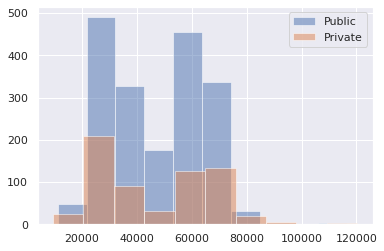

Public school Shapiro-Wilk: (0.929585337638855, 8.196842102747143e-29)
Private, nonprofit Shapiro-Wilk: (0.911332368850708, 6.495935687355362e-19)


In [66]:
# Use histogram and Shapiro-Wilks test to see if data is normally distributed
plt.hist(public_df['MD_EARN_WNE'], label='Public', alpha= .5)
plt.hist(private_df['MD_EARN_WNE'], label='Private', alpha = .5)
plt.legend()
#plt.savefig('bar.png')
#files.download('bar.png')
plt.show()

# From histrogram plot, data doesn't look to be normally distributed but run Shapiro-Wilk test to confirm.
print('Public school Shapiro-Wilk: {}'.format(stats.shapiro(public_df['MD_EARN_WNE'])))
print('Private, nonprofit Shapiro-Wilk: {}'.format(stats.shapiro(private_df['MD_EARN_WNE'])))

# Shapiro-Wilk's test confirms both datasets are not normally distributed due to p-value < .05

In [45]:
# Use Kruskal-Wallis test to compare the differences, if any of the two datasets public_df and private_df
stats.kruskal(public_df['MD_EARN_WNE'], private_df['MD_EARN_WNE'])

# Because p-value is > .05, the null hypothesis is not rejected. There is no stastistically signficant differences between the median earnings of student with a
# STEM degree from a public school compared to a private school.

KruskalResult(statistic=0.032769575628684926, pvalue=0.8563489828138369)

In [46]:
# Another test we can run here is a Mann Whitney U test because the shape of the two distributions are similar.

stats.mannwhitneyu(public_df['MD_EARN_WNE'], private_df['MD_EARN_WNE'])

# Once again, because p-value is > .05, the null hypothesis is not rejected.

MannwhitneyuResult(statistic=644683.0, pvalue=0.42818621106434707)

# Results

Based on my initial results, there is not a statistically significant difference between STEM graduates from a public school versus a private school.  This is important since as previously stated, attending a private school costs more money typically compared to public schools.

However, in considering potential issues in the experiment design, I needed to account for bias and Simpson's Paradox.  Because the data I've run so far is on a national scope and contains subgroups, I wanted to take a closer look at regional comparisons, as well as with each individual STEM general field.

The US Bureau of Economic Analysis separates the US into 9 different economic regions as follows:

1 - New England CT ME MA NH RI VT

2 - Mid East DE DC MD NJ NY PA

3 - Great Lakes IL IN MI OH WI

4 - Plains IA KS MN MO NE ND SD

5 - Southeast AL AR FL GA KY LA MS NC SC TN VA WV

6 - Southwest AZ NM OK TX

7 - Rocky Mountains CO ID MT UT WY

8 - Far West AK CA HI NV OR WA

9 - Outlying territories

The US National Center for Education Statistics, specifically the Integrated Postsecondary Education Data System, are the creaters of the CIP codes and school UNITID's used earlier.  They have also compiled a dataset of all Title IV eligible schools along with their economic region identifier.  This dataset with school UNITID's and their economic region membership is available at https://nces.ed.gov/ipeds/datacenter/DataFiles.aspx.  Specifically, the data file labeled HD2015 was used for my analysis.

Next in my research is looking at economic region subgroups to see if there is a difference at the economic regional level between first year earnings of graduates from public versus private STEM degrees.

In [47]:
# Import CSV file for US economic regions
csv_url = 'https://raw.githubusercontent.com/lvang77/Capstone-1/master/hd2015.csv'

boe_df = pd.read_csv(csv_url, encoding='unicode_escape')

boe_df.info()
boe_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7647 entries, 0 to 7646
Data columns (total 70 columns):
UNITID      7647 non-null int64
INSTNM      7647 non-null object
ADDR        7647 non-null object
CITY        7647 non-null object
STABBR      7647 non-null object
ZIP         7647 non-null object
FIPS        7647 non-null int64
OBEREG      7647 non-null int64
CHFNM       7647 non-null object
CHFTITLE    7647 non-null object
GENTELE     7647 non-null object
EIN         7647 non-null int64
OPEID       7647 non-null int64
OPEFLAG     7647 non-null int64
WEBADDR     7647 non-null object
ADMINURL    7647 non-null object
FAIDURL     7647 non-null object
APPLURL     7647 non-null object
NPRICURL    7647 non-null object
VETURL      7647 non-null object
ATHURL      7647 non-null object
SECTOR      7647 non-null int64
ICLEVEL     7647 non-null int64
CONTROL     7647 non-null int64
HLOFFER     7647 non-null int64
UGOFFER     7647 non-null int64
GROFFER     7647 non-null int64
HDEGOFR1    76

,UNITID,INSTNM,ADDR,CITY,STABBR,ZIP,FIPS,OBEREG,CHFNM,CHFTITLE,GENTELE,EIN,OPEID,OPEFLAG,WEBADDR,ADMINURL,FAIDURL,APPLURL,NPRICURL,VETURL,ATHURL,SECTOR,ICLEVEL,CONTROL,HLOFFER,UGOFFER,GROFFER,HDEGOFR1,DEGGRANT,HBCU,HOSPITAL,MEDICAL,TRIBAL,LOCALE,OPENPUBL,ACT,NEWID,DEATHYR,CLOSEDAT,CYACTIVE,POSTSEC,PSEFLAG,PSET4FLG,RPTMTH,IALIAS,INSTCAT,C15BASIC,C15IPUG,C15IPGRD,C15UGPRF,C15ENPRF,C15SZSET,CCBASIC,CARNEGIE,LANDGRNT,INSTSIZE,CBSA,CBSATYPE,CSA,NECTA,F1SYSTYP,F1SYSNAM,F1SYSCOD,COUNTYCD,COUNTYNM,CNGDSTCD,LONGITUD,LATITUDE,DFRCGID,DFRCUSCG
0,100654,Alabama A & M University,4900 Meridian Street,Normal,AL,35762,1,5,"Dr. Andrew Hugine, Jr.",President,2563725000,636001109,100200,1,www.aamu.edu/,www.aamu.edu/admissions/pages/default.aspx,www.aamu.edu/Admissions/fincialaid/Pages/defau...,www.aamu.edu/admissions/undergraduateadmission...,galileo.aamu.edu/netpricecalculator/npcalc.htm,,www.aamu.edu,1,1,1,9,1,1,12,1,1,2,2,2,12,1,A,-2,-2,-2,1,1,1,1,1,AAMU,2,18,16,18,10,4,13,18,16,1,3,26620,1,290,-2,2,,-2,1089,Madison County,105,-86.568502,34.783368,135,1
1,100663,University of Alabama at Birmingham,Administration Bldg Suite 1070,Birmingham,AL,35294-0110,1,5,Ray L. Watts,President,2059344011,636005396,105200,1,www.uab.edu,www.uab.edu/students/undergraduate-admissions,www.uab.edu/students/paying-for-college,https://idm.uab.edu/myuab/login?from=ugadmapp,www.collegeportraits.org/AL/UAB/estimator/agree,www.uab.edu/students/veterans,www.uabsports.com/compliance/prospects-new.html,1,1,1,9,1,1,11,1,2,1,1,2,12,1,A,-2,-2,-2,1,1,1,1,1,,2,15,14,17,9,5,15,15,15,2,4,13820,1,142,-2,1,The University of Alabama System,101050,1073,Jefferson County,107,-86.809170,33.502230,122,1
2,100690,Amridge University,1200 Taylor Rd,Montgomery,AL,36117-3553,1,5,Michael Turner,President,33438770007528,237034324,2503400,1,www.amridgeuniversity.edu,www.amridgeuniversity.edu/admissions/,www.amridgeuniversity.edu/financial-aid/,https://www.amridgeuniversity.edu/myamridge/,www2.amridgeuniversity.edu:9091/,www.amridgeuniversity.edu/financial-aid/military/,,2,1,2,9,1,1,12,1,2,2,2,2,12,1,A,-2,-2,-2,1,1,1,1,1,Southern Christian University |Regions University,2,20,19,13,5,5,6,21,51,2,1,33860,1,-2,-2,2,,-2,1101,Montgomery County,102,-86.174010,32.362609,250,2
3,100706,University of Alabama in Huntsville,301 Sparkman Dr,Huntsville,AL,35899,1,5,Robert A. Altenkirch,President,2568246120,630520830,105500,1,www.uah.edu,admissions.uah.edu/,finaid.uah.edu/,register.uah.edu,finaid.uah.edu/,www.uah.edu/admissions/graduate/financial-aid/...,www.uah.edu/heoa,1,1,1,9,1,1,11,1,2,2,2,2,12,1,A,-2,-2,-2,1,1,1,1,1,UAH |University of Alabama Huntsville,2,16,17,17,9,4,12,15,16,2,3,26620,1,290,-2,1,The University of Alabama System,101050,1089,Madison County,105,-86.638420,34.722818,125,2
4,100724,Alabama State University,915 S Jackson Street,Montgomery,AL,36104-0271,1,5,Gwen Boyd,President,3342294100,636001101,100500,1,www.alasu.edu,www.alasu.edu/admissions/index.aspx,www.alasu.edu/cost-aid/index.aspx,,www.alasu.edu/cost-aid/forms/calculator/index....,,www.alasu.edu/search-results/index.aspx,1,1,1,9,1,1,11,1,1,2,2,2,12,1,A,-2,-2,-2,1,1,1,1,1,,2,19,13,13,10,3,13,18,21,2,3,33860,1,-2,-2,2,,-2,1101,Montgomery County,107,-86.295677,32.364317,143,1


In [48]:
# filter boe_df and keep only columns UNITID, and OBEREG.  OBEREG is the economic regional identifier, and UNITID is the schools unique identifier as seen earlier.
boe_filtered_df = boe_df[['UNITID', 'OBEREG']]
#boe_filtered_df.info()
#boe_filtered_df.head()

# Merge public_df and boe_filtered_df by UNITID with left inner join
public_df = pd.merge(public_df, boe_filtered_df, how='left')
public_df.groupby(['OBEREG']).count()

# Based on counts for OBEREG regions 1 through 8, sample size is large enough for data analysis. Region 9 sample size is only 10 so we will discard. This should not be significant as region
# 9 are US outlying territories are not part of the 50 states.

,UNITID,OPEID6,INSTNM,CONTROL,CIPCODE,CIPDESC,CREDLEV,CREDDESC,COUNT,DEBTMEDIAN,DEBTPAYMENT10YR,DEBTMEAN,EARNINGSCOUNT,MD_EARN_WNE,cip_2
OBEREG,,,,,,,,,,,,,,,
1,94,94,94,94,94,94,94,94,93,91,91,94,94,94,94
2,237,237,237,237,237,237,237,237,227,225,225,234,231,237,237
3,304,304,304,304,304,304,304,304,302,301,301,304,303,304,304
4,155,155,155,155,155,155,155,155,153,151,151,155,154,155,155
5,467,467,467,467,467,467,467,467,460,456,456,464,463,467,467
6,219,219,219,219,219,219,219,219,216,212,212,217,216,219,219
7,110,110,110,110,110,110,110,110,109,105,105,109,110,110,110
8,325,325,325,325,325,325,325,325,313,320,320,325,313,325,325
9,11,11,11,11,11,11,11,11,10,11,11,11,10,11,11


In [49]:
# Repeat merge process for private_df
boe_filtered2_df = boe_df[['UNITID', 'OBEREG']]
private_df = pd.merge(private_df, boe_filtered2_df, how='left')
private_df.groupby(['OBEREG']).count()

# Discarding region 9 once again. Region 7 only has sample size of 17 but should still be sufficient.

,UNITID,OPEID6,INSTNM,CONTROL,CIPCODE,CIPDESC,CREDLEV,CREDDESC,COUNT,DEBTMEDIAN,DEBTPAYMENT10YR,DEBTMEAN,EARNINGSCOUNT,MD_EARN_WNE,cip_2
OBEREG,,,,,,,,,,,,,,,
1,114,114,114,114,114,114,114,114,104,104,104,110,113,114,114
2,206,206,206,206,206,206,206,206,201,197,197,206,202,206,206
3,120,120,120,120,120,120,120,120,120,117,117,120,120,120,120
4,37,37,37,37,37,37,37,37,37,36,36,37,37,37,37
5,71,71,71,71,71,71,71,71,67,68,68,71,69,71,71
6,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
7,21,21,21,21,21,21,21,21,20,18,18,21,20,21,21
8,72,72,72,72,72,72,72,72,69,70,70,72,70,72,72
9,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11


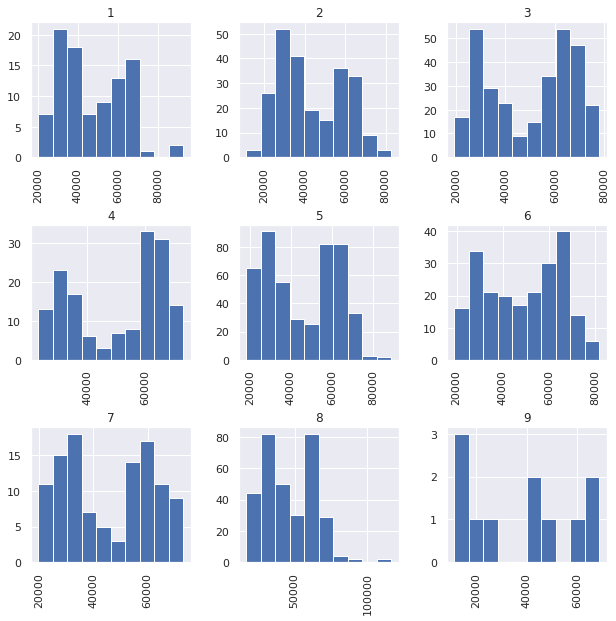

Public Region 1 Shapiro-Wilks: (0.9445242285728455, 0.0005760756321251392)
Public Region 2 Shapiro-Wilks: (0.9365271925926208, 1.3420761391103042e-08)
Public Region 3 Shapiro-Wilks: (0.9082304239273071, 1.1849588150980583e-12)
Public Region 4 Shapiro-Wilks: (0.870397686958313, 2.3960777806308897e-10)
Public Region 5 Shapiro-Wilks: (0.9152077436447144, 1.6044115863273509e-15)
Public Region 6 Shapiro-Wilks: (0.9410103559494019, 9.451838423046866e-08)
Public Region 7 Shapiro-Wilks: (0.9070417881011963, 1.1648518238871475e-06)
Public Region 8 Shapiro-Wilks: (0.9379019141197205, 2.0174546755402645e-10)


In [50]:
# Separate both public_df and private_df into new dataframes based on OBEREG.

# create public and private dataframes for each economic region, public_1-9 and private_1-9.
for i in range(1, 9):
  exec("public_"+str(i)+" = public_df[public_df['OBEREG'] == "+str(i)+"]")
  exec("private_"+str(i)+" = private_df[private_df['OBEREG'] == "+str(i)+"]")

# Check for distribution type of all public regions
public_df['MD_EARN_WNE'].hist(by = public_df['OBEREG'], figsize= (10,10))
plt.show()

for i in range(1, 9):
  exec("print('Public Region "+str(i)+" Shapiro-Wilks: {}'.format(stats.shapiro(public_"+str(i)+"['MD_EARN_WNE'])))")

# Shapiro-Wilks test shows all distributions are not normal due to p-value < .05 along with histogram plots

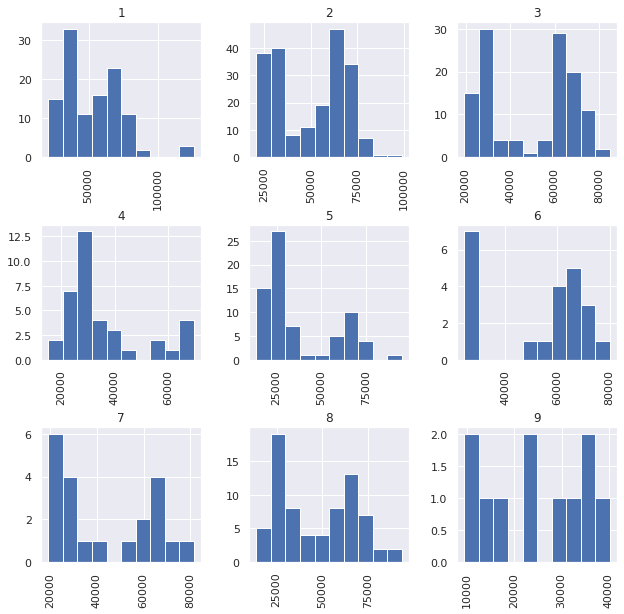

Private Region 1 Shapiro-Wilks: (0.9181346893310547, 3.1681847758591175e-06)
Private Region 2 Shapiro-Wilks: (0.9047732949256897, 3.324523156766901e-10)
Private Region 3 Shapiro-Wilks: (0.8594403266906738, 2.6838877786872217e-09)
Private Region 4 Shapiro-Wilks: (0.813998281955719, 2.523995681258384e-05)
Private Region 5 Shapiro-Wilks: (0.8218909502029419, 8.184360211771491e-08)
Private Region 6 Shapiro-Wilks: (0.811864972114563, 0.0007718838169239461)
Private Region 7 Shapiro-Wilks: (0.8727060556411743, 0.010727197863161564)
Private Region 8 Shapiro-Wilks: (0.9189754128456116, 0.00019274666556157172)


In [51]:
# Repeat for private regions
private_df['MD_EARN_WNE'].hist(by = private_df['OBEREG'], figsize = (10,10))
plt.show()

for i in range(1, 9):
  exec("print('Private Region "+str(i)+" Shapiro-Wilks: {}'.format(stats.shapiro(private_"+str(i)+"['MD_EARN_WNE'])))")

# Histogram plots and Shapiro-Wilks test shows all distributions are not normal

In [52]:
# Test hypothesis for each economic region using Kruskal-Wallis
for i in range(1, 9):
  exec("print('Region "+str(i)+": {}'.format(stats.kruskal(public_"+str(i)+"['MD_EARN_WNE'], private_"+str(i)+"['MD_EARN_WNE'])))")



Region 1: KruskalResult(statistic=2.423293093099355, pvalue=0.11954339164868888)
Region 2: KruskalResult(statistic=14.580208616515586, pvalue=0.0001343178686377925)
Region 3: KruskalResult(statistic=0.10031155573104303, pvalue=0.7514560748809404)
Region 4: KruskalResult(statistic=23.876752224494766, pvalue=1.027045990046539e-06)
Region 5: KruskalResult(statistic=15.80759305295663, pvalue=7.012054323488722e-05)
Region 6: KruskalResult(statistic=1.0147901719418169, pvalue=0.3137579906495894)
Region 7: KruskalResult(statistic=0.6248317462212359, pvalue=0.429257425291093)
Region 8: KruskalResult(statistic=0.0003946076060685584, pvalue=0.9841512788021132)


Based on Kruskal-Wallis test, in regions 2, 4, and 5 there is a statistically significant difference between the median earnings of STEM degree graduates from public to private schools.  The other regions are not statistically different.  This does not match up with our original A/B testing conclusion at the national level and further research is required into why.

Looking deeper into the numbers for regions 2, 4, and 5 shows some large differences in means and median values.  Region 2 for private has a much higher mean and median for earnings compared to public region 2, as well as regions 4 and 5 for public versus private regions 4 and 5 respectively.

In [53]:
# Research deeper into the data for private regions 2, 4, and 5
private_df.groupby(['OBEREG'])['MD_EARN_WNE'].describe()

,count,mean,std,min,25%,50%,75%,max
OBEREG,,,,,,,,
1,114.0,51857.017544,20930.910239,20900.0,34100.0,48750.0,65325.0,126100.0
2,206.0,50149.514563,18935.674803,20700.0,30925.0,55450.0,66325.0,99000.0
3,120.0,49468.333333,19534.842749,19400.0,28250.0,59250.0,66175.0,84900.0
4,37.0,35443.243243,14584.610240,15100.0,26300.0,30000.0,39400.0,69700.0
5,71.0,37108.450704,20266.487091,13700.0,22850.0,27400.0,57750.0,95200.0
6,22.0,52577.272727,19479.853618,24300.0,26725.0,60850.0,68200.0,80100.0
7,21.0,43747.619048,20635.760685,19300.0,24800.0,35300.0,63300.0,81500.0
8,72.0,46933.333333,20691.932156,14000.0,27450.0,48150.0,64800.0,93300.0
9,11.0,24818.181818,10959.089212,9400.0,14600.0,23900.0,34300.0,40200.0


In [54]:
# public regions
public_df.groupby(['OBEREG'])['MD_EARN_WNE'].describe()

,count,mean,std,min,25%,50%,75%,max
OBEREG,,,,,,,,
1,94.0,46753.191489,16085.715978,20000.0,33225.0,43100.0,60575.0,92700.0
2,237.0,43444.303797,16103.403263,11100.0,28800.0,38800.0,58400.0,82800.0
3,304.0,50020.723684,17320.519455,19200.0,31675.0,55250.0,65125.0,78000.0
4,155.0,50479.354839,15847.604992,22900.0,33500.0,58300.0,64100.0,73300.0
5,467.0,45407.708779,17196.137669,18100.0,28150.0,45300.0,61000.0,89000.0
6,219.0,48581.735160,16625.150471,18900.0,32600.0,50600.0,63350.0,81800.0
7,110.0,46000.000000,15944.916650,19700.0,30800.0,45800.0,60275.0,73200.0
8,325.0,46130.461538,17223.464868,16500.0,31200.0,43900.0,61000.0,116600.0
9,11.0,37890.909091,21719.275059,11100.0,18850.0,40600.0,55350.0,68700.0


Further research reveals that region 2 private schools have almost 36% of all nationwide graduates with an Engineering degree (cip_2 value 14) and 33% of Mathmetics and Statistics (cip_2 value 27), the two highest paying degree fields. This results in this region having a disproportionate mean earnings in comparison to the other private school regions. 

In [55]:
# Count number of graduates in each STEM general field as reported by private schools in region 2.
private_2.groupby('cip_2')['MD_EARN_WNE'].describe()


,count,mean,std,min,25%,50%,75%,max
cip_2,,,,,,,,
14,109.0,65022.018349,8349.455048,44400.0,60800.0,65100.0,69500.0,99000.0
26,77.0,28975.324675,4729.864687,20700.0,25100.0,28600.0,32500.0,40300.0
27,14.0,54371.428571,16566.622077,29300.0,41450.0,52050.0,67675.0,79700.0
40,6.0,41850.000000,16806.040581,24300.0,32000.0,35050.0,54075.0,65300.0


In [56]:
# Count number of graduates in each STEM general field as reported by private schools nationally.
private_df.groupby('cip_2')['MD_EARN_WNE'].describe()

,count,mean,std,min,25%,50%,75%,max
cip_2,,,,,,,,
14,307.0,64660.586319,10350.721154,16200.0,60600.0,65000.0,69300.0,116600.0
26,304.0,28220.723684,6051.500493,9400.0,24575.0,27600.0,31600.0,48200.0
27,46.0,59691.304348,20082.671647,29300.0,44100.0,56500.0,70925.0,126100.0
40,17.0,39805.882353,14379.563214,23700.0,31000.0,35100.0,45300.0,73900.0


Further reseach into region 4 comparison for public and private schools shows more issues with the data collected. Private school region 4 is made up almost entirely of the lowest paying STEM degree Biological and Biomedical Science (cip_2 code 26).  Looking into public region 4, it shows that 58% of reported graduates were in the highest paying STEM field.

In [57]:
private_4.groupby('cip_2')['MD_EARN_WNE'].describe()

,count,mean,std,min,25%,50%,75%,max
cip_2,,,,,,,,
14,6.0,63750.000000,4931.835358,55500.0,61875.0,65350.0,65750.0,69700.0
26,26.0,27376.923077,4276.662969,15100.0,25450.0,27450.0,30075.0,34600.0
27,4.0,44925.000000,8484.250114,39400.0,39400.0,41500.0,47025.0,57300.0
40,1.0,37400.000000,NaN,37400.0,37400.0,37400.0,37400.0,37400.0


In [58]:
public_4.groupby('cip_2')['MD_EARN_WNE'].describe()

,count,mean,std,min,25%,50%,75%,max
cip_2,,,,,,,,
14,90.0,62774.444444,5402.487174,45500.0,59725.0,63100.0,66450.0,73300.0
26,51.0,31205.882353,6126.741769,22900.0,27900.0,30600.0,33500.0,65000.0
27,9.0,45000.000000,5469.460668,37400.0,41600.0,43500.0,48300.0,54100.0
40,5.0,35620.000000,3103.546359,31800.0,33400.0,35500.0,38600.0,38800.0


Due to smaller sample sizes and large disparaties in the data at a regional level, regional subgroup testing for Simpson's Paradox is inaccurate. However, in doing this further research, there's a large disparity in the earnings within the 4 STEM fields. Let's do one last subgroup testing of each individual 2 digit CIP STEM field at a national level to make sure it agrees with our original hypothesis null conclusion that there is no statistical significance in earnings based on going to a public or private school.

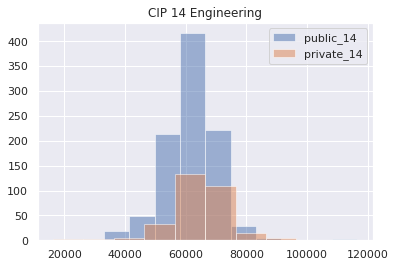

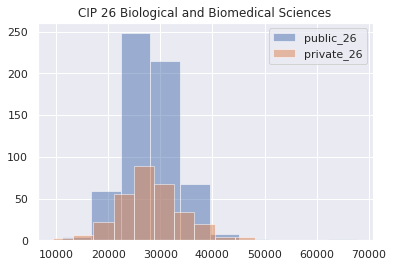

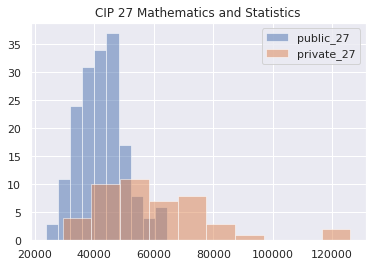

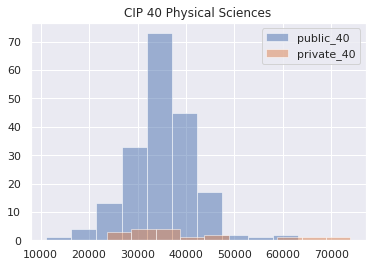

In [59]:
# Separate public_df and private_df into cip_2 datasets
public_14 = public_df[public_df['cip_2'] == 14]
public_26 = public_df[public_df['cip_2'] == 26]
public_27 = public_df[public_df['cip_2'] == 27]
public_40 = public_df[public_df['cip_2'] == 40]

private_14 = private_df[private_df['cip_2'] == 14]
private_26 = private_df[private_df['cip_2'] == 26]
private_27 = private_df[private_df['cip_2'] == 27]
private_40 = private_df[private_df['cip_2'] == 40]

# histogram plot comparisons of each STEM general field
f1 = plt.figure(1)
plt.hist(public_14['MD_EARN_WNE'], alpha = .5, label='public_14')
plt.hist(private_14['MD_EARN_WNE'], alpha = .5, label='private_14')
plt.title('CIP 14 Engineering')
plt.legend()
f1.show()

f2 = plt.figure(2)
plt.hist(public_26['MD_EARN_WNE'], alpha = .5, label='public_26')
plt.hist(private_26['MD_EARN_WNE'], alpha = .5, label='private_26')
plt.title('CIP 26 Biological and Biomedical Sciences')
plt.legend()
f2.show()

f3 = plt.figure(3)
plt.hist(public_27['MD_EARN_WNE'], alpha = .5, label='public_27')
plt.hist(private_27['MD_EARN_WNE'], alpha = .5, label='private_27')
plt.title('CIP 27 Mathematics and Statistics')
plt.legend()
f3.show()

f4 = plt.figure(4)
plt.hist(public_40['MD_EARN_WNE'], alpha = .5, label='public_40')
plt.hist(private_40['MD_EARN_WNE'], alpha = .5, label='private_40')
plt.title('CIP 40 Physical Sciences')
plt.legend()
f4.show()

In [60]:
# Histogram plots show these datasets don't seem to be normally distributed but do Shapiro-Wilks test to confirm.
print('Public 14 (Engineering) Shapiro: {}'.format(stats.shapiro(public_14['MD_EARN_WNE'])))
print('Public 26 (Biological and Biomedical Sciences) Shapiro: {}'.format(stats.shapiro(public_26['MD_EARN_WNE'])))
print('Public 27 (Mathematics and Statistics) Shapiro: {}'.format(stats.shapiro(public_27['MD_EARN_WNE'])))
print('Public 40 (Physical Sciences) Shapiro: {}'.format(stats.shapiro(public_40['MD_EARN_WNE'])))


print('Private 14 (Engineering) Shapiro: {}'.format(stats.shapiro(private_14['MD_EARN_WNE'])))
print('Private 26 (Biological and Biomedical Sciences) Shapiro: {}'.format(stats.shapiro(private_26['MD_EARN_WNE'])))
print('Private 27 (Mathematics and Statistics) Shapiro: {}'.format(stats.shapiro(private_27['MD_EARN_WNE'])))
print('Private 40 (Physical Sciences) Shapiro: {}'.format(stats.shapiro(private_40['MD_EARN_WNE'])))

# Shapiro-Wilks confirms data is not normally distributed for all except public schools cip_2 code 27. However, the p-value is at .07 so we will proceed to use Kruskal-Wallis to compare each cip_2 code STEM field's earnings.

Public 14 (Engineering) Shapiro: (0.9643656611442566, 1.6753967801313475e-14)
Public 26 (Biological and Biomedical Sciences) Shapiro: (0.9331095218658447, 8.810199854442015e-16)
Public 27 (Mathematics and Statistics) Shapiro: (0.9858693480491638, 0.0749964788556099)
Public 40 (Physical Sciences) Shapiro: (0.9582064151763916, 1.9847671865136363e-05)
Private 14 (Engineering) Shapiro: (0.9086397886276245, 1.077632666261763e-12)
Private 26 (Biological and Biomedical Sciences) Shapiro: (0.9888136386871338, 0.01934608444571495)
Private 27 (Mathematics and Statistics) Shapiro: (0.9026252031326294, 0.0010000093607231975)
Private 40 (Physical Sciences) Shapiro: (0.8657929301261902, 0.018848055973649025)


In [61]:
print('14 (Engineering): {}'.format(stats.kruskal(public_14['MD_EARN_WNE'], private_14['MD_EARN_WNE'])))
print('26 (Biological and Biomedical Sciences) {}'.format(stats.kruskal(public_26['MD_EARN_WNE'], private_26['MD_EARN_WNE'])))
print('27 (Mathematics and Statistics): {}'.format(stats.kruskal(public_27['MD_EARN_WNE'], private_27['MD_EARN_WNE'])))
print('40 (Physical Sciences): {}'.format(stats.kruskal(public_40['MD_EARN_WNE'], private_40['MD_EARN_WNE'])))


14 (Engineering): KruskalResult(statistic=36.5984230400998, pvalue=1.4514909336049843e-09)
26 (Biological and Biomedical Sciences) KruskalResult(statistic=0.09760223543674501, pvalue=0.7547262427442147)
27 (Mathematics and Statistics): KruskalResult(statistic=38.02132325822146, pvalue=6.997567269263354e-10)
40 (Physical Sciences): KruskalResult(statistic=0.5697855143923332, pvalue=0.45034415983145804)


Kruskal Wallis test of STEM general field subgroup shows that CIP code 14 Engineering and CIP code 27 Mathematics and Statistics shows a statistically significant difference in first year earnings of public versus private school graduates.

# Final Conclusions and Discussion

Looking at economic region subgroups and STEM general field subgroups reveals Simpson's Paradox with some of the subgroups not aligning with the original null hypothesis that there is no statistically significant difference in first year earnings of STEM graduates from public versus private schools.

To arrive at a conclusion on which results to accept, we have to consider the way how the original data is gathered.  The US DOE College Scorecard's dataset is gathered from two different sources.  First, they use what Title IV eligible postsecondary schools report to them about graduates in each CIP field.  As we saw in the original dataset, many schools choose to omit certain fields in some of their degrees.  As such, the reporting of individual graduates within each specific degree is completely voluntary.

Secondly, for the College Scorecard to get median earnings for each school's specific degree graduates, they matched the school's reported Title IV receiving student to their respective first year earnings after graduation as reported by the IRS.  The problem with this is that there is no way to know if graduates are working in their career field within the first year of graduation.  One could argue that the higher earning Engineering and Mathematics/Statistics graduates could be getting into their career fields must faster than the other two STEM fields.

Without having explicit data that says whether the first year earnings were from within a career related to their STEM degree and due to the voluntary reporting of individual students at the specific degree level, I choose to use the original national region for all STEM fields as my final conclusion, in that there is no difference in first year earnings of STEM graduates with a bachelor's degree from public schools versus private schools.

Lastly below, I run a quick scatterplot to compare median debt and median earnings of STEM graduates for both public and private schools that will be used in my presentation.

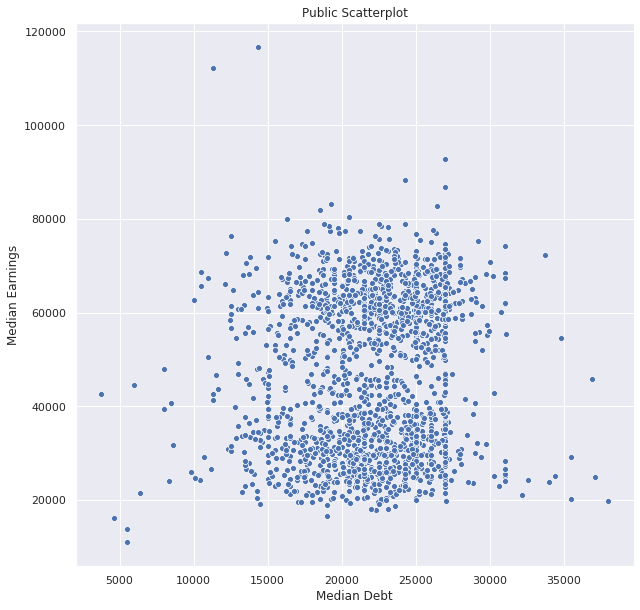

In [62]:

# Drop NaN values for DEBTMEDIAN
public_df.dropna(subset=['DEBTMEDIAN'], inplace=True)
private_df.dropna(subset=['DEBTMEDIAN'], inplace=True)

# Convert dataframe column datatype from object to int64
public_df = public_df.astype({'DEBTMEDIAN':'int64'})
private_df = private_df.astype({'DEBTMEDIAN':'int64'})

figure(num=None, figsize=(10,10))
sns.scatterplot(x='DEBTMEDIAN', y='MD_EARN_WNE', data=public_df)
plt.title('Public Scatterplot')
plt.xlabel('Median Debt')
plt.ylabel('Median Earnings')
#plt.savefig('public.png')
#files.download('public.png')
plt.show()

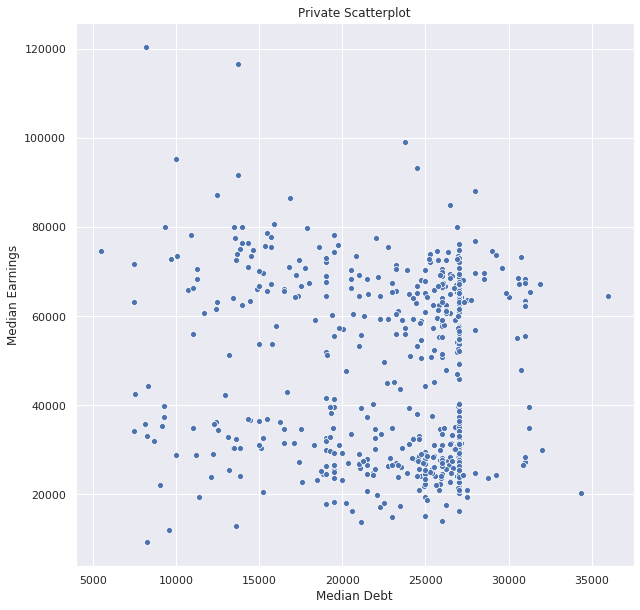

In [63]:
figure(num=None, figsize=(10,10))
sns.scatterplot(x='DEBTMEDIAN', y='MD_EARN_WNE', data=private_df)
plt.title('Private Scatterplot')
plt.xlabel('Median Debt')
plt.ylabel('Median Earnings')
#plt.savefig('private.png')
#files.download('private.png')
plt.show()